In [1]:
#QFT with swap static circuit

In [2]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from math import pi

def get_qft_circuit_static_swap(num_qubit):
    #Initialize the quantum circuit
    qr=QuantumRegister(num_qubit)
    cr3=ClassicalRegister(num_qubit,name="cr3")
    qc=QuantumCircuit(qr,cr3)
    
    # Apply the QFT
    for j in range(num_qubit):
        qc.h(j)
        for k in range(j + 1, num_qubit):
            qc.cp(pi / 2**(k - j), k, j)
    
    # Reverse the order of the qubits
    for i in range(num_qubit // 2):
        qc.swap(i, num_qubit - i - 1)

    #Final measurement
    for i in range(num_qubit):
        qc.measure(qr[i],cr3[i])
    
    return qc

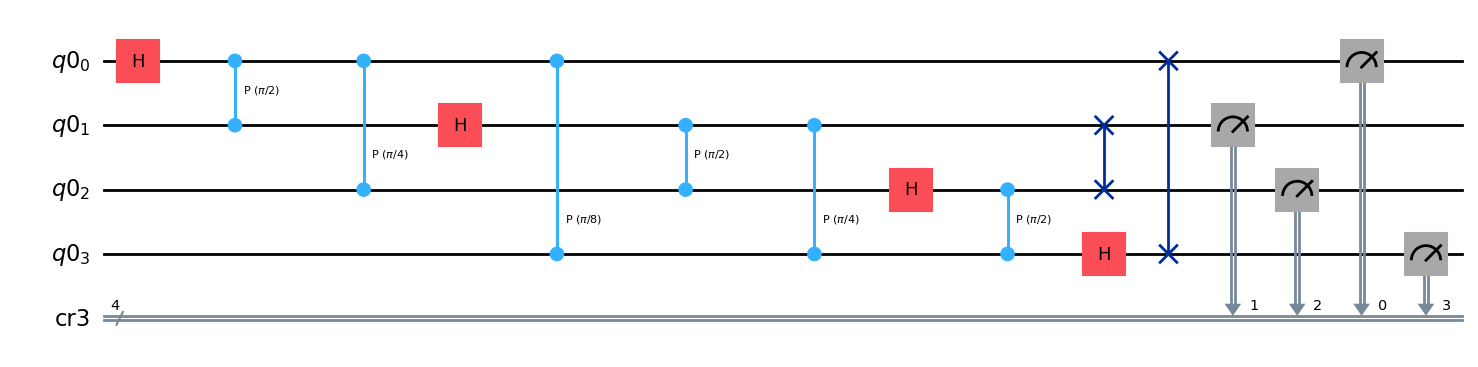

In [3]:
qc = get_qft_circuit_static_swap(num_qubit=4)
qc.draw('mpl')

In [4]:
#QFT with swap dynamic circuit

In [5]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.classical import expr
from math import pi

def get_qft_circuit_dynamic_swap(num_qubit):
    #Initialize the quantum circuit
    qr=QuantumRegister(num_qubit)
    cr1=ClassicalRegister(num_qubit,name="cr1")
    cr2=ClassicalRegister(num_qubit,name="cr2")
    qc=QuantumCircuit(qr,cr1,cr2)

    for j in range(num_qubit):
        qc.h(j)
        #Mid-circuit measurement
        qc.measure(qr[j],cr1[j])
        for k in range(j + 1, num_qubit):
            with qc.if_test((j, 1)):
                qc.p(pi / 2**(k - j), k)

    # Reverse the order of the qubits
    for i in range(num_qubit // 2):
        qc.swap(i, num_qubit - i - 1)

    qc.barrier()

    #Final measurement
    for i in range(num_qubit):
        qc.measure(qr[i],cr2[i])
    
    return qc

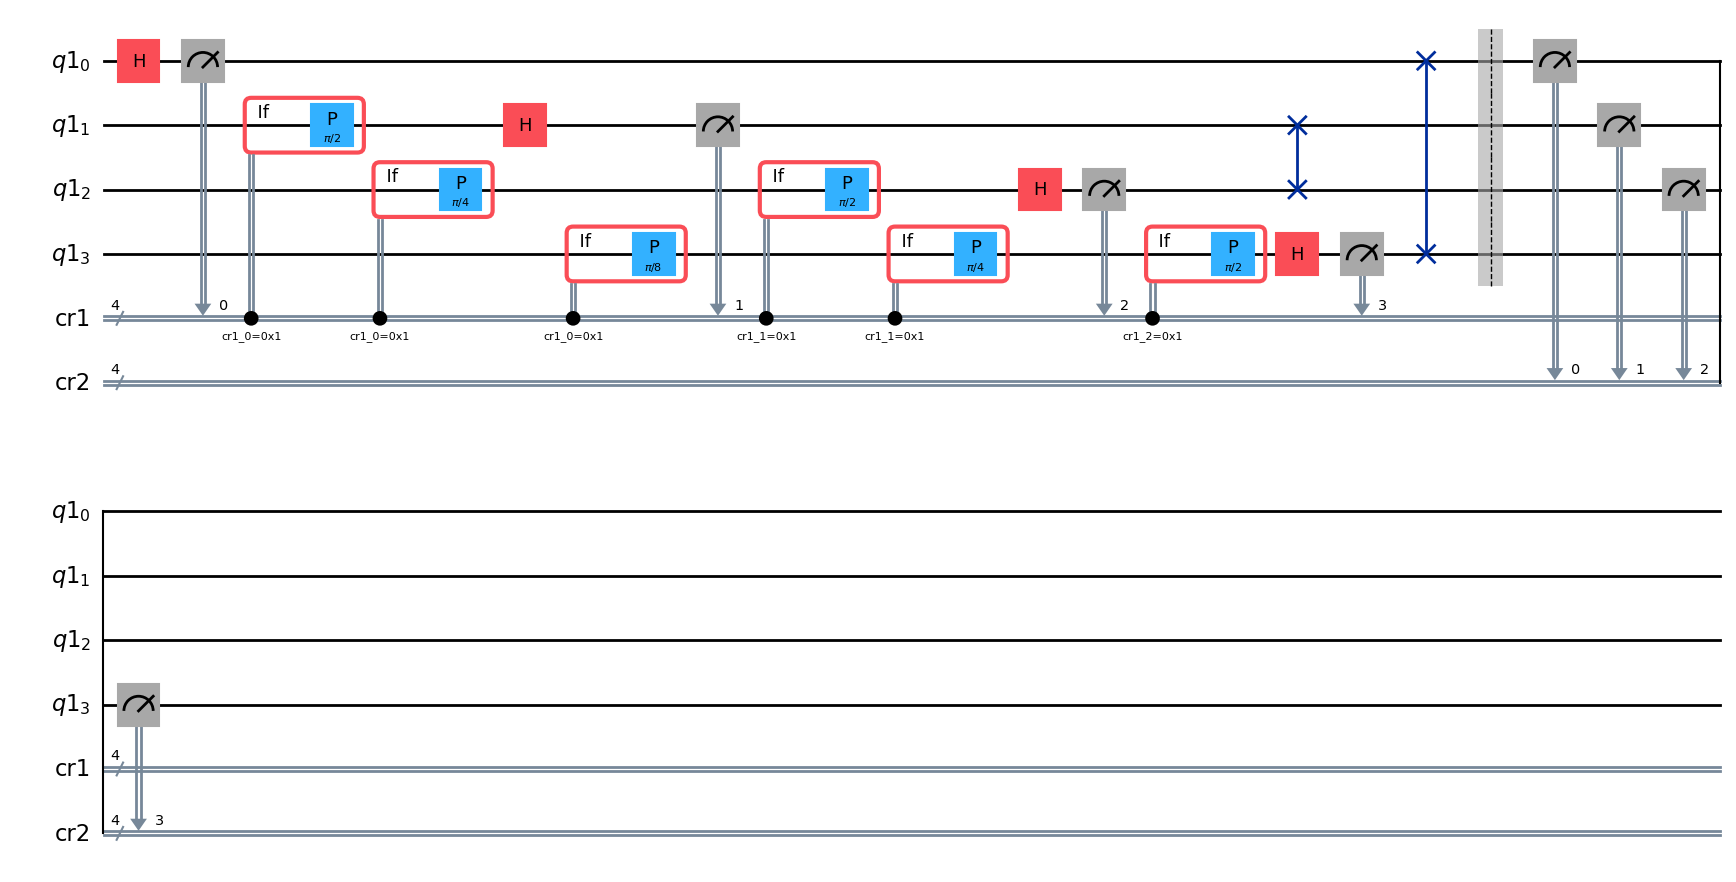

In [6]:
qc = get_qft_circuit_dynamic_swap(num_qubit=4)
qc.draw('mpl')

In [7]:
#Creating list of circuits[Static_1, Dynamic_1, Static_1, Dynamic_1,...,Static_2, Dynamic_2, Static_2, Dynamic_2,...] i.e. some copies of each of them

min_qubit=11
max_num_qubit=14
copies=1

#qc_list_static=[]
#qc_list_dynamic=[]
#observables=[]

qc_list=[]
num_qubit_list=list(range(min_qubit,max_num_qubit+1))
for num_qubit in num_qubit_list:
    for i in range(copies):
        qc_list.append(get_qft_circuit_static_swap(num_qubit))
        qc_list.append(get_qft_circuit_dynamic_swap(num_qubit))
print(num_qubit_list)

[11, 12, 13, 14]


In [8]:
#Ideal Simulation with AerSimulator
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler
 
aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1, basis_gates=['snapshot', 'store', 'measure', 'barrier', 'h', 'cx'], translation_method='translator')
qc_transpiled_list=[]

qc_transpiled_list_ideal = pm.run(qc_list)

In [9]:
sampler = Sampler(backend=aer_sim)
result_ideal = sampler.run(qc_transpiled_list_ideal).result()

In [10]:
print(result_ideal)
len(result_ideal)

PrimitiveResult([PubResult(data=DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=11>))), PubResult(data=DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=11>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=11>))), PubResult(data=DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=12>))), PubResult(data=DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=12>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=12>))), PubResult(data=DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=13>))), PubResult(data=DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=13>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=13>))), PubResult(data=DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=14>))), PubResult(data=DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=14>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=14>)))], metadata={})


8

In [11]:
# For getting list of ideal counts (argument required for Fidelity)
counts_list_ideal=[]
for i in range(len(num_qubit_list)):  
    for j in range(copies):
        data_static_swap = result_ideal[(2*i*copies)+(2*j)].data    
        data_dynamic_swap = result_ideal[(2*i*copies)+((2*j)+1)].data 

        print(data_static_swap)
        print(data_dynamic_swap)
        
        counts_static_swap=data_static_swap.cr3.get_counts()
        counts_dynamic_swap=data_dynamic_swap.cr2.get_counts()
        
        counts_list_ideal.append(counts_static_swap)
        counts_list_ideal.append(counts_dynamic_swap)

DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=11>))
DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=11>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=11>))
DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=12>))
DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=12>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=12>))
DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=13>))
DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=13>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=13>))
DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=14>))
DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=14>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=14>))


In [12]:
# Simulation of real hardware to get result_real
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler, QiskitRuntimeService
 
 
service = QiskitRuntimeService()
 
# Specify a system to use for the noise model
real_backend = service.backend("ibm_brisbane")
aer = AerSimulator.from_backend(real_backend)
 
# Run the sampler job locally using AerSimulator.
pm = generate_preset_pass_manager(backend=aer, optimization_level=1)
qc_transpiled_list_real = pm.run(qc_list)
sampler = Sampler(backend=aer)
result_brisbane = sampler.run(qc_transpiled_list_real).result()

In [13]:
# Simulation of real hardware to get result_real
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler, QiskitRuntimeService
 
 
service = QiskitRuntimeService()
 
# Specify a system to use for the noise model
real_backend = service.backend("ibm_sherbrooke")
aer = AerSimulator.from_backend(real_backend)
 
# Run the sampler job locally using AerSimulator.
pm = generate_preset_pass_manager(backend=aer, optimization_level=1)
qc_transpiled_list_real = pm.run(qc_list)
sampler = Sampler(backend=aer)
result_sherbrooke = sampler.run(qc_transpiled_list_real).result()

In [14]:
# Simulation of real hardware to get result_real
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler, QiskitRuntimeService
 
 
service = QiskitRuntimeService()
 
# Specify a system to use for the noise model
real_backend = service.backend("ibm_osaka")
aer = AerSimulator.from_backend(real_backend)
 
# Run the sampler job locally using AerSimulator.
pm = generate_preset_pass_manager(backend=aer, optimization_level=1)
qc_transpiled_list_real = pm.run(qc_list)                               
sampler = Sampler(backend=aer)
result_osaka = sampler.run(qc_transpiled_list_real).result()

In [15]:
# Simulation of real hardware to get result_real
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler, QiskitRuntimeService
 
 
service = QiskitRuntimeService()
 
# Specify a system to use for the noise model
real_backend = service.backend("ibm_kyoto")
aer = AerSimulator.from_backend(real_backend)
 
# Run the sampler job locally using AerSimulator.
pm = generate_preset_pass_manager(backend=aer, optimization_level=1)
qc_transpiled_list_real = pm.run(qc_list)                                
sampler = Sampler(backend=aer)
result_kyoto = sampler.run(qc_transpiled_list_real).result()

In [16]:
#get list counts_list_brisbane, counts_list_sherbrooke, counts_list_osaka, counts_list_kyoto (argument required for Fidelity)
counts_list_brisbane=[]
counts_list_sherbrooke=[]
counts_list_osaka=[]
counts_list_kyoto=[]
for i in range(len(num_qubit_list)):  
    for j in range(copies):
        data_static_swap = result_brisbane[(2*i*copies)+(2*j)].data
        data_dynamic_swap = result_brisbane[(2*i*copies)+((2*j)+1)].data
        counts_static_swap=data_static_swap.cr3.get_counts()
        counts_dynamic_swap=data_dynamic_swap.cr2.get_counts()
        counts_list_brisbane.append(counts_static_swap)
        counts_list_brisbane.append(counts_dynamic_swap)

        data_static_swap = result_sherbrooke[(2*i*copies)+(2*j)].data
        data_dynamic_swap = result_sherbrooke[(2*i*copies)+((2*j)+1)].data
        counts_static_swap=data_static_swap.cr3.get_counts()
        counts_dynamic_swap=data_dynamic_swap.cr2.get_counts()
        counts_list_sherbrooke.append(counts_static_swap)
        counts_list_sherbrooke.append(counts_dynamic_swap)
        
        data_static_swap = result_osaka[(2*i*copies)+(2*j)].data
        data_dynamic_swap = result_osaka[(2*i*copies)+((2*j)+1)].data
        counts_static_swap=data_static_swap.cr3.get_counts()
        counts_dynamic_swap=data_dynamic_swap.cr2.get_counts()
        counts_list_osaka.append(counts_static_swap)
        counts_list_osaka.append(counts_dynamic_swap)

        data_static_swap = result_kyoto[(2*i*copies)+(2*j)].data
        data_dynamic_swap = result_kyoto[(2*i*copies)+((2*j)+1)].data
        counts_static_swap=data_static_swap.cr3.get_counts()
        counts_dynamic_swap=data_dynamic_swap.cr2.get_counts()
        counts_list_kyoto.append(counts_static_swap)
        counts_list_kyoto.append(counts_dynamic_swap)

In [17]:
#Calculation of lists of Fidelity mean and std deviation of all 4 hardware simulation
import statistics
from qiskit.quantum_info.analysis import hellinger_fidelity
# We will create 4 lists of Fidelities, for storing mean, std deviation of Fidelity, of copies of a circuit for fixed no of logical qubits
# For GHZ state analysis: index 0 of these lists store informationn of GHZ state having 3 qubits, index 1 for 4 qubits and so on 
Fidelity_mean_static_swap_brisbane=[]
Fidelity_mean_dynamic_swap_brisbane=[]
#Fidelity_std_static_swap_brisbane=[]
#Fidelity_std_dynamic_swap_brisbane=[]
Fidelity_copies_static_swap_brisbane=[]
Fidelity_copies_dynamic_swap_brisbane=[]

Fidelity_mean_static_swap_sherbrooke=[]
Fidelity_mean_dynamic_swap_sherbrooke=[]
#Fidelity_std_static_swap_sherbrooke=[]
#Fidelity_std_dynamic_swap_sherbrooke=[]
Fidelity_copies_static_swap_sherbrooke=[]
Fidelity_copies_dynamic_swap_sherbrooke=[]

Fidelity_mean_static_swap_osaka=[]
Fidelity_mean_dynamic_swap_osaka=[]
#Fidelity_std_static_swap_osaka=[]
#Fidelity_std_dynamic_swap_osaka=[]
Fidelity_copies_static_swap_osaka=[]
Fidelity_copies_dynamic_swap_osaka=[]

Fidelity_mean_static_swap_kyoto=[]
Fidelity_mean_dynamic_swap_kyoto=[]
#Fidelity_std_static_swap_kyoto=[]
#Fidelity_std_dynamic_swap_kyoto=[]
Fidelity_copies_static_swap_kyoto=[]
Fidelity_copies_dynamic_swap_kyoto=[]
for i in range(len(num_qubit_list)):
    
    for j in range(copies):
        
        Fidelity_static_swap= hellinger_fidelity(counts_list_ideal[(2*i*copies)+(2*j)], counts_list_brisbane[(2*i*copies)+(2*j)])
        Fidelity_dynamic_swap=hellinger_fidelity(counts_list_ideal[(2*i*copies)+((2*j)+1)], counts_list_brisbane[(2*i*copies)+((2*j)+1)])
        Fidelity_copies_static_swap_brisbane.append(Fidelity_static_swap)
        Fidelity_copies_dynamic_swap_brisbane.append(Fidelity_dynamic_swap)

        Fidelity_static_swap= hellinger_fidelity(counts_list_ideal[(2*i*copies)+(2*j)], counts_list_sherbrooke[(2*i*copies)+(2*j)])
        Fidelity_dynamic_swap=hellinger_fidelity(counts_list_ideal[(2*i*copies)+((2*j)+1)], counts_list_sherbrooke[(2*i*copies)+((2*j)+1)])
        Fidelity_copies_static_swap_sherbrooke.append(Fidelity_static_swap)
        Fidelity_copies_dynamic_swap_sherbrooke.append(Fidelity_dynamic_swap)

        Fidelity_static_swap= hellinger_fidelity(counts_list_ideal[(2*i*copies)+(2*j)], counts_list_osaka[(2*i*copies)+(2*j)])
        Fidelity_dynamic_swap=hellinger_fidelity(counts_list_ideal[(2*i*copies)+((2*j)+1)], counts_list_osaka[(2*i*copies)+((2*j)+1)])
        Fidelity_copies_static_swap_osaka.append(Fidelity_static_swap)
        Fidelity_copies_dynamic_swap_osaka.append(Fidelity_dynamic_swap)

        Fidelity_static_swap= hellinger_fidelity(counts_list_ideal[(2*i*copies)+(2*j)], counts_list_kyoto[(2*i*copies)+(2*j)])
        Fidelity_dynamic_swap=hellinger_fidelity(counts_list_ideal[(2*i*copies)+((2*j)+1)], counts_list_kyoto[(2*i*copies)+((2*j)+1)])
        Fidelity_copies_static_swap_kyoto.append(Fidelity_static_swap)
        Fidelity_copies_dynamic_swap_kyoto.append(Fidelity_dynamic_swap)

    
    Fidelity_mean_static_swap_brisbane.append(statistics.mean(Fidelity_copies_static_swap_brisbane))
    Fidelity_mean_dynamic_swap_brisbane.append(statistics.mean(Fidelity_copies_dynamic_swap_brisbane))
    #Fidelity_std_static_swap_brisbane.append(statistics.stdev(Fidelity_copies_static_swap_brisbane))
    #Fidelity_std_dynamic_swap_brisbane.append(statistics.stdev(Fidelity_copies_dynamic_swap_brisbane))
    Fidelity_copies_static_swap_brisbane.clear()
    Fidelity_copies_dynamic_swap_brisbane.clear()

    Fidelity_mean_static_swap_sherbrooke.append(statistics.mean(Fidelity_copies_static_swap_sherbrooke))
    Fidelity_mean_dynamic_swap_sherbrooke.append(statistics.mean(Fidelity_copies_dynamic_swap_sherbrooke))
    #Fidelity_std_static_swap_sherbrooke.append(statistics.stdev(Fidelity_copies_static_swap_sherbrooke))
    #Fidelity_std_dynamic_swap_sherbrooke.append(statistics.stdev(Fidelity_copies_dynamic_swap_sherbrooke))
    Fidelity_copies_static_swap_sherbrooke.clear()
    Fidelity_copies_dynamic_swap_sherbrooke.clear()

    Fidelity_mean_static_swap_osaka.append(statistics.mean(Fidelity_copies_static_swap_osaka))
    Fidelity_mean_dynamic_swap_osaka.append(statistics.mean(Fidelity_copies_dynamic_swap_osaka))
    #Fidelity_std_static_swap_osaka.append(statistics.stdev(Fidelity_copies_static_swap_osaka))
    #Fidelity_std_dynamic_swap_osaka.append(statistics.stdev(Fidelity_copies_dynamic_swap_osaka))
    Fidelity_copies_static_swap_osaka.clear()
    Fidelity_copies_dynamic_swap_osaka.clear()

    Fidelity_mean_static_swap_kyoto.append(statistics.mean(Fidelity_copies_static_swap_kyoto))
    Fidelity_mean_dynamic_swap_kyoto.append(statistics.mean(Fidelity_copies_dynamic_swap_kyoto))
    #Fidelity_std_static_swap_kyoto.append(statistics.stdev(Fidelity_copies_static_swap_kyoto))
    #Fidelity_std_dynamic_swap_kyoto.append(statistics.stdev(Fidelity_copies_dynamic_swap_kyoto))
    Fidelity_copies_static_swap_kyoto.clear()
    Fidelity_copies_dynamic_swap_kyoto.clear()

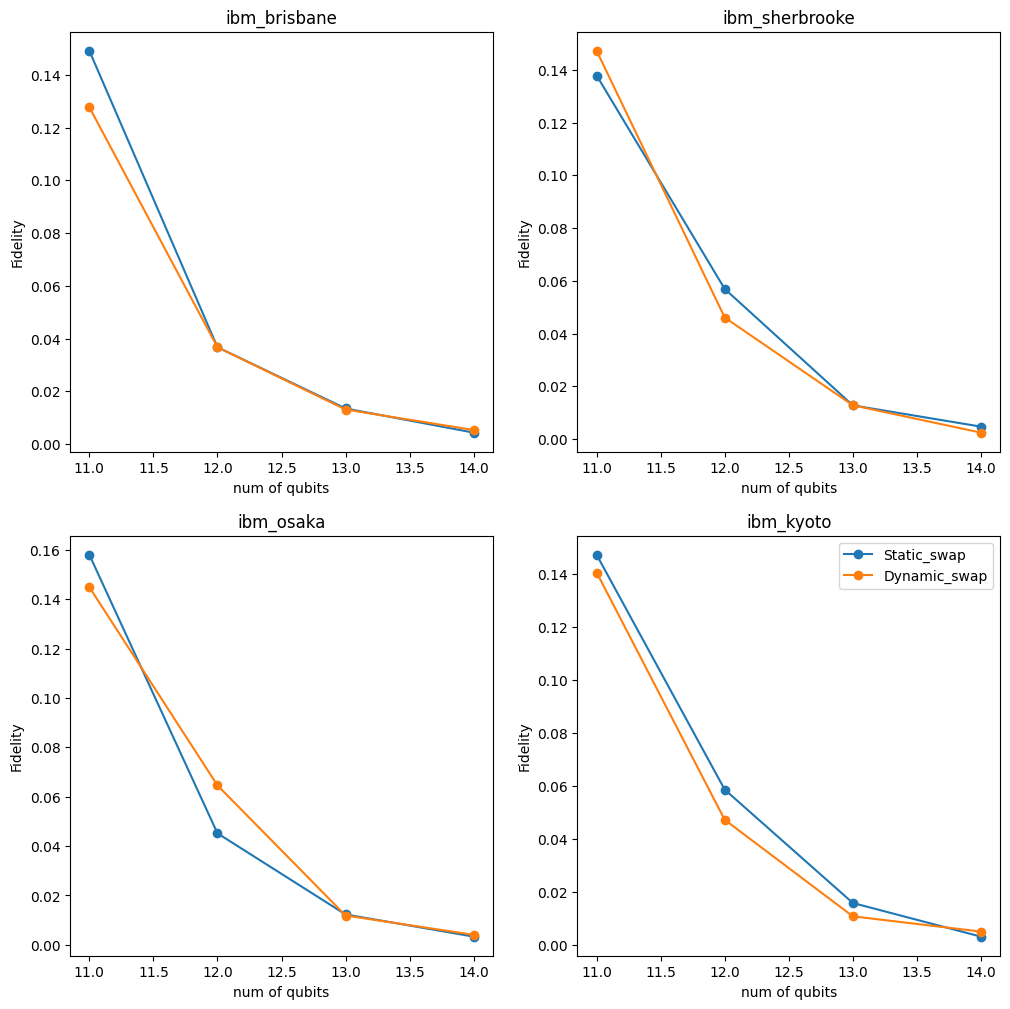

In [18]:
# Graph plotting
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
#figure(figsize=(16,12), dpi=180)
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(12,12))

# Create  data.
ax1.set_xlabel('num of qubits')
ax1.set_ylabel('Fidelity')
ax1.set_title('ibm_brisbane')
x1 = num_qubit_list
y1_static_swap = Fidelity_mean_static_swap_brisbane
y1_dynamic_swap = Fidelity_mean_dynamic_swap_brisbane
#y_error_static_swap =Fidelity_std_static_swap_brisbane
#y_error_dynamic_swap =Fidelity_std_dynamic_swap_brisbane
ax1.plot(x1, y1_static_swap, 'o-',label='Static_swap')
ax1.plot(x1, y1_dynamic_swap, 'o-',label='Dynamic_swap')
#ax1.errorbar(x1, y1_static_swap,
			#yerr = y_error_static_swap, label='static_swap',
			#fmt ='o')
#ax1.errorbar(x1, y1_dynamic_swap,
			#yerr = y_error_dynamic_swap, label='dynamic_swap',
			#fmt ='o')

ax2.set_xlabel('num of qubits')
ax2.set_ylabel('Fidelity')
ax2.set_title('ibm_sherbrooke')
x2 = num_qubit_list
y2_static_swap = Fidelity_mean_static_swap_sherbrooke
y2_dynamic_swap = Fidelity_mean_dynamic_swap_sherbrooke
#y_error_static_swap =Fidelity_std_static_swap_sherbrooke
#y_error_dynamic_swap =Fidelity_std_dynamic_swap_sherbrooke
ax2.plot(x2, y2_static_swap, 'o-',label='Static_swap')
ax2.plot(x2, y2_dynamic_swap, 'o-',label='Dynamic_swap')
#ax2.errorbar(x2, y2_static_swap,
			#yerr = y_error_static_swap, label='static_swap',
			#fmt ='o')
#ax2.errorbar(x2, y2_dynamic_swap,
			#yerr = y_error_dynamic_swap, label='dynamic_swap',
			#fmt ='o')

ax3.set_xlabel('num of qubits')
ax3.set_ylabel('Fidelity')
ax3.set_title('ibm_osaka')
x3 = num_qubit_list
y3_static_swap = Fidelity_mean_static_swap_osaka
y3_dynamic_swap = Fidelity_mean_dynamic_swap_osaka
#y_error_static_swap =Fidelity_std_static_swap_osaka
#y_error_dynamic_swap =Fidelity_std_dynamic_swap_osaka
ax3.plot(x3, y3_static_swap, 'o-',label='Static_swap')
ax3.plot(x3, y3_dynamic_swap, 'o-',label='Dynamic_swap')
#ax3.errorbar(x3, y3_static_swap,
			#yerr = y_error_static_swap, label='static_swap',
			#fmt ='o')
#ax3.errorbar(x3, y3_dynamic_swap,
			#yerr = y_error_dynamic_swap, label='dynamic_swap',
			#fmt ='o')

ax4.set_xlabel('num of qubits')
ax4.set_ylabel('Fidelity')
ax4.set_title('ibm_kyoto')
x4 = num_qubit_list
y4_static_swap = Fidelity_mean_static_swap_kyoto
y4_dynamic_swap = Fidelity_mean_dynamic_swap_kyoto
#y_error_static_swap =Fidelity_std_static_swap_kyoto
#y_error_dynamic_swap =Fidelity_std_dynamic_swap_kyoto
ax4.plot(x4, y4_static_swap, 'o-',label='Static_swap')
ax4.plot(x4, y4_dynamic_swap, 'o-',label='Dynamic_swap')
#ax4.errorbar(x4, y4_static_swap,
			#yerr = y_error_static_swap, label='static_swap',
			#fmt ='o')
#ax4.errorbar(x4, y4_dynamic_swap,
			#yerr = y_error_dynamic_swap, label='dynamic_swap',
			#fmt ='o')


plt.legend()
plt.show()